## Introduction

The notebook provided is centered around a machine learning competition with the objective of developing a model that can distinguish between essays written by students and those generated by large language models (LLMs). The notebook includes sections like introduction, loading the training dataset, and exploring the dataset.

Key aspects of the notebook include:

- `Introduction`: Explains the competition's goal, which is to create a model capable of accurately detecting if an essay was authored by a student or produced by an LLM.

- `Load Training Dataset`: Focuses on loading the dataset used for training the model.

- `Dataset Fields`: Describes the fields in the training data, including unique identifiers for each essay (id), prompt identifiers (prompt_id), essay text (text), and a target label indicating whether the essay was student-written (0) or LLM-generated (1).

- `Data Exploration`: Initial analysis to check for null values and understand the dataset's size, which includes 1378 rows.

In [1]:
# Import Libraries

import re
import string
import numpy as np
import pandas as pd
from numpy import array

## Explore Dataset

In [2]:
# Load train_essays dataset
train = pd.read_csv("train_essays.csv")
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Training Data has following fields:

`id` - A unique identifier for each essay

`prompt_id` - Identifies the prompt the essay was written in response to

`text` - The essay text itself

`generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


There are no null values, there are 1378 rows in the training data

<AxesSubplot: xlabel='prompt_id', ylabel='count'>

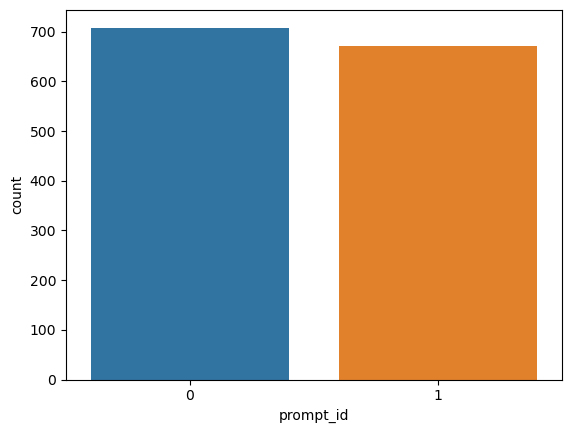

In [4]:
import seaborn as sns
sns.countplot(data=train,x="prompt_id")

We have enough data for both the prompt ids

<AxesSubplot: xlabel='generated', ylabel='count'>

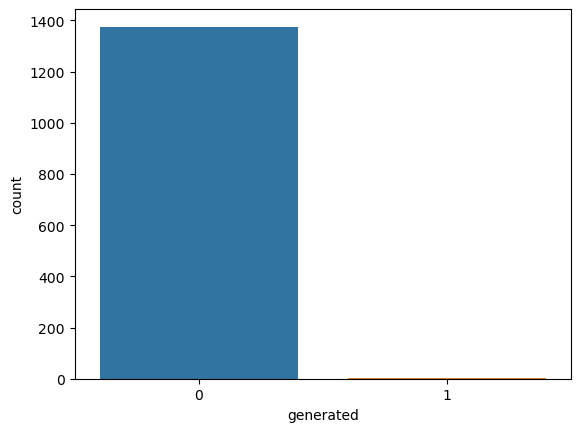

In [5]:
# Class Distribution
sns.countplot(data=train,x="generated")

Traning dataset seems to be highly imbalanced

## train_prompts file

Every essay was created in response to one of seven specific prompts. In these prompts, students were asked to read certain source texts and then write their responses. For the essays generated by a large language model (LLM), this source material may or may not have been used as input.

The training set is comprised of essays from two of these prompts, while essays from the other five prompts make up the concealed test set. The majority of essays in the training set are student-written, with a small number of LLM-generated essays included for reference. It might be beneficial to create additional LLM-generated essays for use in the training process.

In [6]:
train_prompts = pd.read_csv("train_prompts.csv")
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


Essays were created based on specific details outlined in the following fields:

- **`prompt_id`**: This is a unique identifier assigned to each prompt.
- **`prompt_name`**: Refers to the name or title of the prompt.
- **`instructions`**: These are the guidelines provided to the students for writing the essays.
- **`source_text`**: This is the text of one or more articles that the essays are based on, formatted in Markdown. Key paragraphs in these articles are marked with a numeral at the beginning of the paragraph (e.g., 0 for the first paragraph, 1 for the second, etc.). Essays may reference these paragraphs using their numeral. Each article begins with its title in a header format, like '# Title.' If an author's name is included, it appears in the title following the word 'by,' although not all articles mention an author. Some articles might also include subheadings, formatted as '## Subheading.'

In [ ]:
from nltk.corpus import stopwords
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
import tensorflow as tf

In [8]:
train[train.generated==1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


There are only 3 such essays

Since the training data is higly imbalanced, we are going to use external training data provided by :

Proper Train Dataset @thedrcat

In [9]:
df1 = pd.read_csv("train_drcat_01.csv",usecols=['text','label'])
df2 = pd.read_csv("train_drcat_02.csv",usecols=['text','label'])
df3 = pd.read_csv("train_drcat_03.csv",usecols=['text','label'])
df4 = pd.read_csv("train_drcat_04.csv",usecols=['text','label'])
train = pd.read_csv("train_essays.csv",usecols=["text","generated"])

df1 = df1.rename(columns={'label': 'generated'})
df2 = df2.rename(columns={'label': 'generated'})
df3 = df3.rename(columns={'label': 'generated'})
df4 = df4.rename(columns={'label': 'generated'})

train_essays = pd.concat([df1,df2,df3,df4,train], ignore_index=True, sort=False)
if (df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + train.shape[0]) == train_essays.shape[0]:
    print("merge successful")

    
train_essays.head()

merge successful


,text,generated
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0


In [10]:
#train_essays['generated'] = train_essays.label.copy()
train_essays.generated.value_counts()

0    116747
1     44087
Name: generated, dtype: int64

## Data Preparation & Model Building

In [11]:

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [12]:
# load all essays in the training dataset
def process_docs(df):
    documents = list()
    # walk through all files in the folder
    for idx,row in df.iterrows():
        # load the doc
        doc = row.text
        # clean doc
        tokens = clean_doc(doc)
        # add to list
        documents.append(tokens)
    return documents

In [13]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

In [15]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [16]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(32, 4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D()(drop1)
    flat1 = Flatten()(pool1)
    
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(32, 6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D()(drop2)
    flat2 = Flatten()(pool2)
    
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(32, 8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D()(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])
    
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    
    # summarize
    model.summary()
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
# load training dataset
trainLines = process_docs(train_essays)
trainLabels = train_essays.generated.values

# imports 
from sklearn.utils import class_weight



class_weights = class_weight.compute_class_weight(
class_weight = "balanced",
classes = np.unique(trainLabels),
y = trainLabels
)
class_weights = dict(zip(np.unique(trainLabels), class_weights))


# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], array(trainLabels),class_weight=class_weights,epochs=20, batch_size=16)
# save the model
model.save('model_llm')

## Test dataset

In [ ]:
test_essays = pd.read_csv("test_essays.csv")
test_essays.head()

In [ ]:
testLines = process_docs(test_essays)
# encode data
testX = encode_text(tokenizer, testLines, length)
print(testX.shape)

In [ ]:
predictions = model.predict([testX,testX,testX])
predictions

In [ ]:
# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['id'] = test_essays["id"]
sub['score'] = predictions
sub.to_csv('submission.csv',index=False)